## Imports

In [1]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.data import ConcatDataset, DataLoader

from scipy.stats import mode

import os
import numpy as np
import tifffile
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import skew, kurtosis
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels


In [3]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [4]:


def plot_band_histogram(X, band=0, timestep=0, title_prefix=""):

    band_data = X[timestep, band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram @ t={timestep}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()






In [5]:

band_sums = np.zeros(BANDS, dtype=np.float64)
band_sqsums = np.zeros(BANDS, dtype=np.float64)
band_counts = np.zeros(BANDS, dtype=np.int64)
all_data = []

for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))

        for tile_id in tqdm(tile_ids[:2500:50], desc=f"{region}/{year}"):
            tile_path = os.path.join(tiles_root, tile_id)
            try:
                X = load_image_stack(tile_path)  # (T, 9, 48, 48)
                y = load_mask(tile_path)        # (48, 48)
                
                # Compute stats
                for b in range(BANDS):
                    band_data = X[:, b, :, :].astype(np.float64)
                    band_sums[b] += band_data.sum()
                    band_sqsums[b] += (band_data ** 2).sum()
                    band_counts[b] += band_data.size

                all_data.append((X, y))
            except Exception as e:
                print(f"❌ Failed to load {tile_path}: {e}")

# mean and std
means = band_sums / band_counts
stds = np.sqrt(band_sqsums / band_counts - means ** 2)
print("\n📊 Per-band means:", np.round(means, 2))
print("📊 Per-band stds: ", np.round(stds, 2))




lombardia2/data2018: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


📊 Per-band means: [2952.5  3018.91 2968.34 3337.96 3925.21 4176.8  4288.54 2897.55 2256.18]
📊 Per-band stds:  [3462.45 3186.53 3102.4  3046.9  2640.6  2530.34 2574.45 1482.25 1364.91]



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 | 8274.64  468.43 6755.00 9455.00 7977.00 8265.00 8588.00   -0.26    0.23
   1 | 7683.49  456.67 6276.00 8859.00 7356.00 7669.00 7998.25   -0.07   -0.19
   2 | 7107.09  463.16 5852.00 8306.00 6748.00 7106.00 7415.25    0.07   -0.48
   3 | 7266.61  442.02 6166.00 8256.00 6924.75 7264.00 7565.00    0.07   -0.63
   4 | 7374.47  444.94 6118.00 8564.00 7054.00 7414.00 7704.00   -0.18   -0.46
   5 | 7282.92  441.95 6042.00 8466.00 6997.00 7323.00 7610.00   -0.29   -0.28
   6 | 7493.34  435.42 6197.00 8727.00 7187.00 7501.00 7811.50   -0.23   -0.15
   7 | 5393.29  323.04 4564.00 6251.00 5156.50 5393.00 5630.00   -0.01   -0.62
   8 | 4895.02  320.77 3997.00 5704.00 4660.00 4900.00 5129.00   -0.10   -0.45


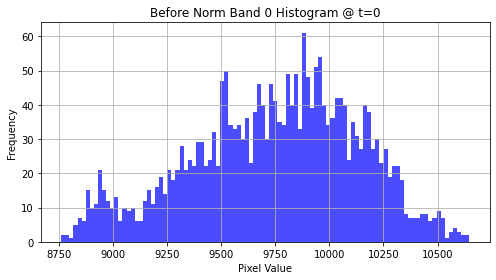

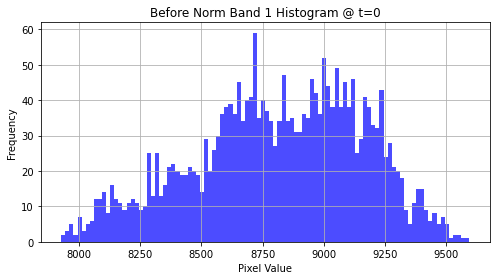

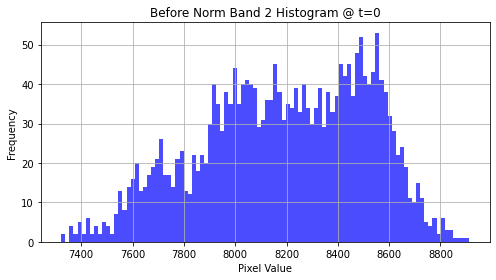

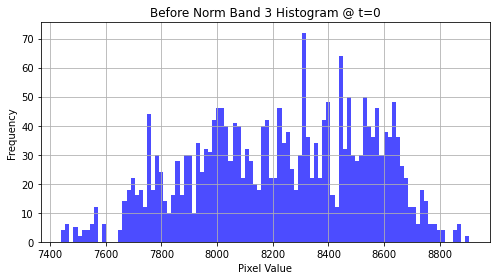

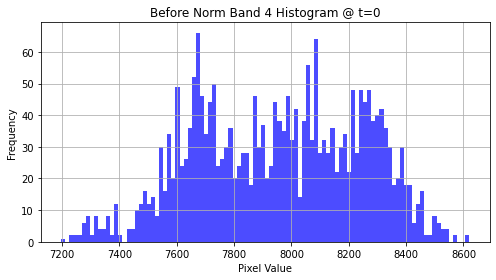

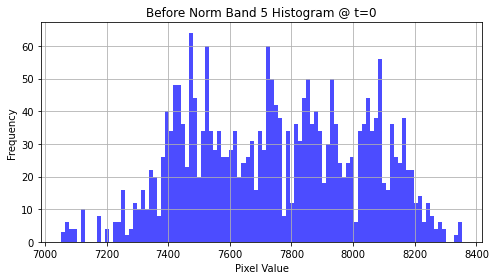

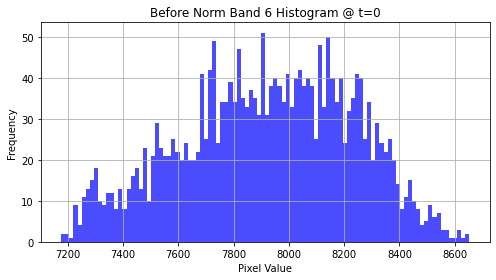

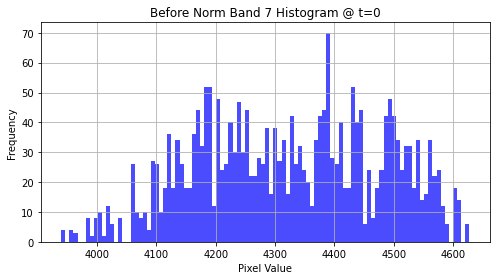

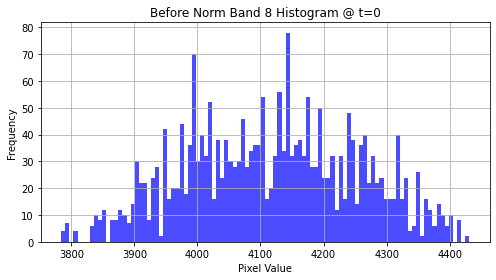

In [6]:


def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="Before Norm")

In [7]:
#Z-score normalisaiton
for i in range(len(all_data)):
    X, y = all_data[i]
    X = X.astype(np.float32)  
    for b in range(BANDS):
        X[:, b] = (X[:, b] - means[b]) / stds[b]
    all_data[i] = (X, y)



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 |    1.54    0.14    1.10    1.88    1.45    1.53    1.63   -0.26    0.23
   1 |    1.46    0.14    1.02    1.83    1.36    1.46    1.56   -0.07   -0.19
   2 |    1.33    0.15    0.93    1.72    1.22    1.33    1.43    0.07   -0.48
   3 |    1.29    0.15    0.93    1.61    1.18    1.29    1.39    0.07   -0.63
   4 |    1.31    0.17    0.83    1.76    1.18    1.32    1.43   -0.18   -0.46
   5 |    1.23    0.17    0.74    1.70    1.11    1.24    1.36   -0.29   -0.28
   6 |    1.24    0.17    0.74    1.72    1.13    1.25    1.37   -0.23   -0.15
   7 |    1.68    0.22    1.12    2.26    1.52    1.68    1.84   -0.01   -0.62
   8 |    1.93    0.24    1.28    2.53    1.76    1.94    2.10   -0.10   -0.45


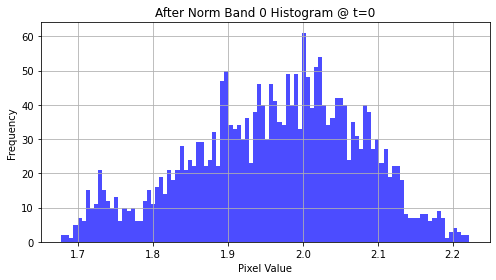

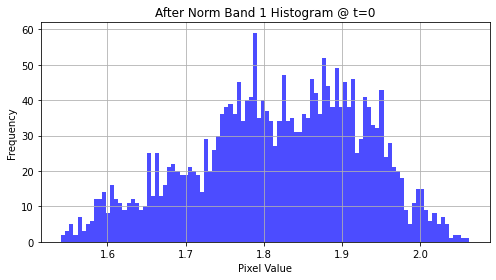

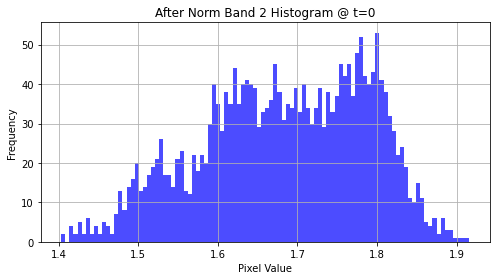

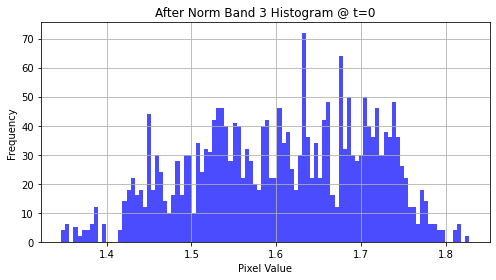

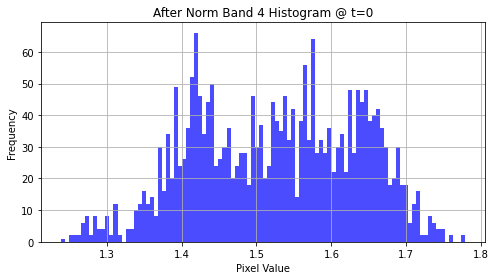

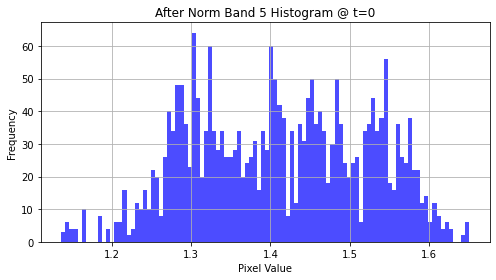

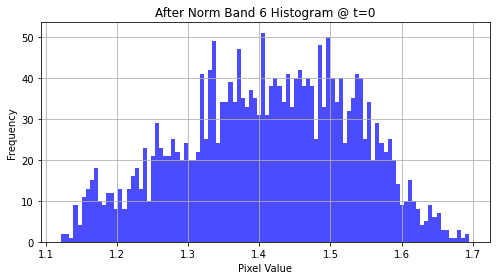

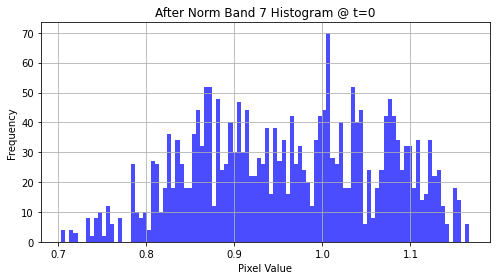

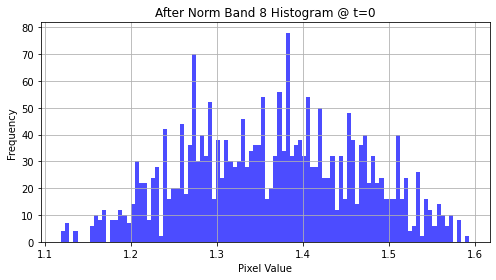

In [8]:

def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="After Norm")

In [10]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())



# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 691200
📊 Label Frequencies:
  Label 0: 57054 pixels
  Label 1: 139425 pixels
  Label 2: 148646 pixels
  Label 3: 66047 pixels
  Label 4: 103588 pixels
  Label 5: 49222 pixels
  Label 6: 127218 pixels


In [11]:

label_counter = Counter()

for _, mask in all_data:
    unique, counts = np.unique(mask, return_counts=True)
    label_counter.update(dict(zip(unique, counts)))

print("Class pixel counts:", dict(label_counter))

num_classes = 7
total_pixels = sum(label_counter.values())

weights = []
for cls in range(num_classes):
    cls_count = label_counter.get(cls, 0)
    if cls_count == 0:
        weights.append(0.0)  # Unused class
    else:
        freq = cls_count / total_pixels
        weights.append(1.0 / freq)

# Step 5: Convert to torch.Tensor
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class pixel counts: {0: 57054, 1: 139425, 3: 66047, 4: 103588, 5: 49222, 6: 127218, 2: 148646}
Class weights: tensor([12.1148,  4.9575,  4.6500, 10.4653,  6.6726, 14.0425,  5.4332],
       device='cuda:0')


In [12]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 300
Train samples: 240
Test samples:  60


In [13]:

def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)



📊 Unique Time Step Counts:
  T = 33: 42 tiles
  T = 34: 42 tiles
  T = 53: 72 tiles
  T = 68: 45 tiles
  T = 71: 39 tiles

🧮 Total Unique T values: 5


defaultdict(int, {34: 42, 53: 72, 68: 45, 71: 39, 33: 42})

Image sequence shape: (34, 9, 48, 48)
Ground truth shape: (48, 48)


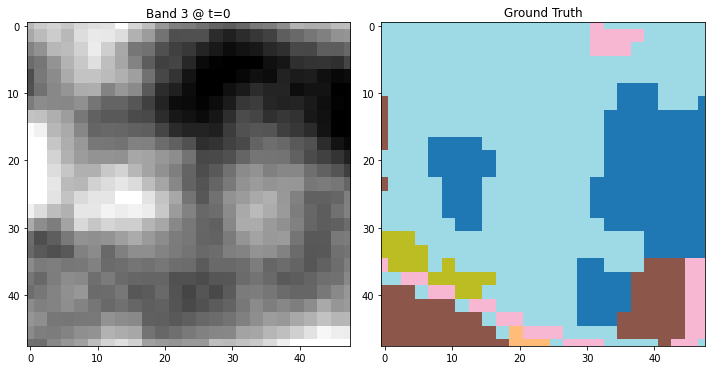

In [14]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img = X[timestep, band]
    
    # Normalize visualization range to make contrast visible
    vmin = np.percentile(img, 2)
    vmax = np.percentile(img, 98)

    axs[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Band {band} @ t={timestep}')

    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=3)


# Model

In [15]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=9, out_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):  # x: (B, 9, 48, 48)
        return self.net(x)  # (B, C, 48, 48)


In [16]:
class CNN_LSTM_Segmentation(nn.Module):
    def __init__(self, cnn_feat_dim=64, lstm_hidden=64, num_classes=7, chunk_size=256):
        super().__init__()
        self.cnn = CNNEncoder(in_channels=9, out_channels=cnn_feat_dim)
        self.lstm = nn.LSTM(input_size=cnn_feat_dim, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Conv2d(lstm_hidden * 2, num_classes, kernel_size=1)
        self.chunk_size = chunk_size

    def forward(self, x):  # x: (B, T, 9, H, W)
        B, T, C, H, W = x.shape

        # CNN feature extraction for each timestep
        feat_seq = []
        for t in range(T):
            feat = self.cnn(x[:, t])  # (B, cnn_feat_dim, H, W)
            feat_seq.append(feat)

        feat_seq = torch.stack(feat_seq, dim=1)      # (B, T, cnn_feat_dim, H, W)
        feat_seq = feat_seq.permute(0, 3, 4, 1, 2)   # (B, H, W, T, cnn_feat_dim)
        feat_seq = feat_seq.reshape(B * H * W, T, -1)  # (N, T, cnn_feat_dim), where N = B*H*W

        # Chunked LSTM over pixels
        outputs = []
        for i in range(0, feat_seq.shape[0], self.chunk_size):
            chunk = feat_seq[i:i + self.chunk_size]     # (chunk_size, T, cnn_feat_dim)
            lstm_out, _ = self.lstm(chunk)              # (chunk_size, T, 2H)
            lstm_last = lstm_out[:, -1, :]              # (chunk_size, 2H)
            outputs.append(lstm_last)

        lstm_last = torch.cat(outputs, dim=0)           # (B*H*W, 2H)

        # Reshape to (B, 2H, H, W)
        lstm_last = lstm_last.view(B, H, W, -1).permute(0, 3, 1, 2)

        # Classifier
        out = self.classifier(lstm_last)  # (B, num_classes, H, W)
        return out

In [17]:
class TileDataset(Dataset):
    def __init__(self, tile_data, window_size=25):
        self.data = tile_data
        self.window = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


# Training

In [18]:

train_dataset = TileDataset(train_raw, window_size=25)
val_dataset = TileDataset(val_raw, window_size=25)

#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

batch_size = 10

# List of all unique T values
time_steps = [33, 34, 53, 68, 71]

# Create train loaders for each T
train_loaders = []
for T in time_steps:
    subset = [d for d in train_raw if d[0].shape[0] == T]
    if subset:  # Only add loader if there's data for this T
        loader = DataLoader(TileDataset(subset), batch_size=batch_size, shuffle=True)
        train_loaders.append(loader)

# Create val loaders for each T
val_loaders = []
for T in time_steps:
    subset = [d for d in val_raw if d[0].shape[0] == T]
    if subset:
        loader = DataLoader(TileDataset(subset), batch_size=batch_size, shuffle=False)
        val_loaders.append(loader)



model = CNN_LSTM_Segmentation().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Configurable
window_size = 10
stride = 4

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for train_loader in train_loaders:
        train_loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False)
        for X_tile, y_tile in train_loop:
            X_tile = X_tile.to(device)  # (B, T, 9, 48, 48)
            y_tile = y_tile.to(device)  # (B, 48, 48)
            B, T, C, H, W = X_tile.shape

            logits_accum = []

            # Sliding windows
            for i in range(0, T - window_size + 1, stride):
                window = X_tile[:, i:i+window_size]  # (B, W, 9, 48, 48)
                out = model(window)  # (B, num_classes, 48, 48)
                logits_accum.append(out)  # (B, num_classes, 48, 48)

            if not logits_accum:
                continue  # skip batch if no valid windows

            # Average logits over all windows
            avg_logits = torch.stack(logits_accum, dim=0).mean(0)  # (B, num_classes, 48, 48)

            # Compute loss
            loss = criterion(avg_logits, y_tile)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = avg_logits.argmax(1)  # (B, 48, 48)
            correct += (pred == y_tile).sum().item()
            total += y_tile.numel()

            train_loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    train_loss = running_loss / sum(len(dl) for dl in train_loaders)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ===== Validation =====
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    for val_loader in val_loaders:
        val_loop = tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for X_tile, y_tile in val_loop:
                X_tile = X_tile.to(device)
                y_tile = y_tile.to(device)
                B, T, C, H, W = X_tile.shape

                logits_accum = []

                for i in range(0, T - window_size + 1, stride):
                    window = X_tile[:, i:i+window_size]
                    out = model(window)
                    logits_accum.append(out)

                if not logits_accum:
                    continue

                avg_logits = torch.stack(logits_accum, dim=0).mean(0)  # (B, num_classes, 48, 48)
                loss = criterion(avg_logits, y_tile)
                val_loss += loss.item()

                pred = avg_logits.argmax(1)  # (B, 48, 48)
                correct += (pred == y_tile).sum().item()
                total += y_tile.numel()

    val_loss /= sum(len(dl) for dl in val_loaders)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}] ✅ "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/10] ✅ Train Loss: 1.9578, Train Acc: 0.1007, Val Loss: 1.9443, Val Acc: 0.1222


Epoch [2/10] ✅ Train Loss: 1.9460, Train Acc: 0.1584, Val Loss: 1.9431, Val Acc: 0.1301


Epoch [3/10] ✅ Train Loss: 1.9326, Train Acc: 0.1413, Val Loss: 1.9216, Val Acc: 0.0611


Epoch [4/10] ✅ Train Loss: 1.8807, Train Acc: 0.1596, Val Loss: 1.8109, Val Acc: 0.2161


Epoch [5/10] ✅ Train Loss: 1.7648, Train Acc: 0.2088, Val Loss: 1.7430, Val Acc: 0.2292


Epoch [6/10] ✅ Train Loss: 1.7508, Train Acc: 0.2966, Val Loss: 1.7021, Val Acc: 0.3808


Epoch [7/10] ✅ Train Loss: 1.6816, Train Acc: 0.3275, Val Loss: 1.6606, Val Acc: 0.3002


Epoch [8/10] ✅ Train Loss: 1.6702, Train Acc: 0.3306, Val Loss: 1.6222, Val Acc: 0.2395


Epoch [9/10] ✅ Train Loss: 1.6774, Train Acc: 0.3061, Val Loss: 1.6404, Val Acc: 0.2993


Epoch [10/10] ✅ Train Loss: 1.6230, Train Acc: 0.3590, Val Loss: 1.6146, Val Acc: 0.3332


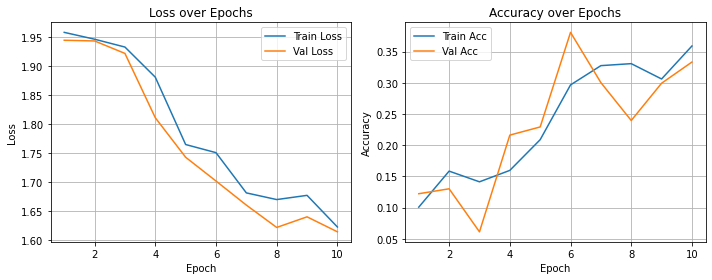

Train Losses: [1.96, 1.95, 1.93, 1.88, 1.76, 1.75, 1.68, 1.67, 1.68, 1.62]
Val Losses: [1.94, 1.94, 1.92, 1.81, 1.74, 1.7, 1.66, 1.62, 1.64, 1.61]
Train Accuracies (%): [10.07, 15.84, 14.13, 15.96, 20.88, 29.66, 32.75, 33.06, 30.61, 35.9]
Val Accuracies (%): [12.22, 13.01, 6.11, 21.61, 22.92, 38.08, 30.02, 23.95, 29.93, 33.32]


In [22]:
epochs = range(1, len(train_losses)+1)


# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



train_losses_rounded = [round(x, 2) for x in train_losses]
val_losses_rounded = [round(x, 2) for x in val_losses]
train_accuracies_rounded = [round(x * 100, 2) for x in train_accuracies] 
val_accuracies_rounded = [round(x * 100, 2) for x in val_accuracies] 

print("Train Losses:", train_losses_rounded)
print("Val Losses:", val_losses_rounded)
print("Train Accuracies (%):", train_accuracies_rounded)
print("Val Accuracies (%):", val_accuracies_rounded)

# Evalutaion

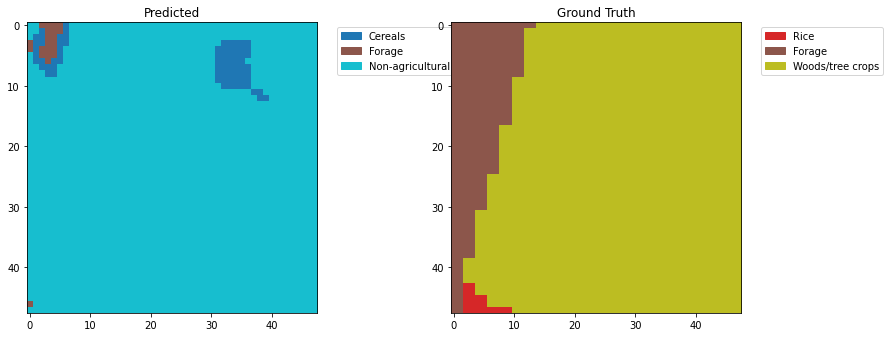

🔍 Evaluating Loader 1/5 with 42 samples
🔍 Evaluating Loader 2/5 with 42 samples
🔍 Evaluating Loader 3/5 with 72 samples
🔍 Evaluating Loader 4/5 with 45 samples
🔍 Evaluating Loader 5/5 with 39 samples

📊 Ground Truth Pixel Count Per Class (Total):
  Cereals: 48062
  Maize: 108180
  Rice: 109574
  Forage: 58164
  Unknown crop: 86694
  Woods/tree crops: 41182
  Non-agricultural: 101104

🤖 Predicted Pixel Count Per Class (Total):
  Cereals: 16703
  Maize: 2393
  Rice: 50623
  Forage: 56531
  Unknown crop: 168975
  Woods/tree crops: 7012
  Non-agricultural: 250723

✅ Per-pixel Accuracy (Total): 0.2263


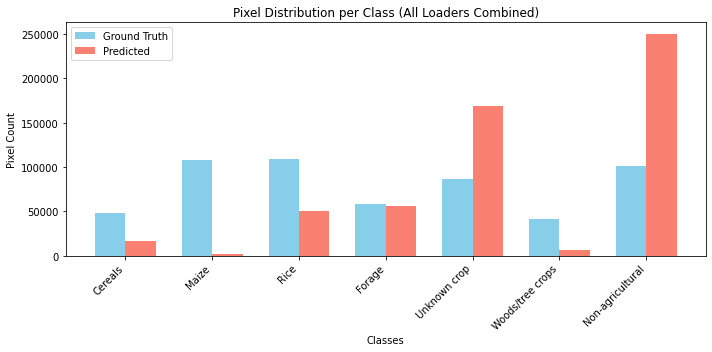

In [23]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None):
    import matplotlib.patches as mpatches

    model.eval()
    X, y = dataset[idx]
    X = X.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(X).argmax(1).squeeze().cpu().numpy()
    
    y = y.numpy()

    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    # Create color map and legends with names
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes]
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Predicted")
    plt.legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    plt.imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Ground Truth")
    plt.legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()



def evaluate_combined(model, loaders, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    with torch.no_grad():
        for i, loader in enumerate(loaders):
            print(f"🔍 Evaluating Loader {i+1}/{len(loaders)} with {len(loader.dataset)} samples")
            for X, y in loader:
                X, y = X.to(device), y.to(device)
                preds = model(X).argmax(1)

                preds_np = preds.cpu().numpy().flatten()
                y_np = y.cpu().numpy().flatten()

                for cls in range(num_classes):
                    pred_counts[cls] += np.sum(preds_np == cls)
                    gt_counts[cls] += np.sum(y_np == cls)

                correct += np.sum(preds_np == y_np)
                total += y_np.size

    print("\n📊 Ground Truth Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    print(f"\n✅ Per-pixel Accuracy (Total): {correct / total:.4f}")

    # === Plotting the distributions ===
    class_names = [label_names[cls] for cls in range(num_classes)]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)

    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')

    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class (All Loaders Combined)")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()





label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}



visualize(model, train_dataset, idx=8, num_classes=7, label_names=label_names)
evaluate_combined(model, train_loaders, label_names, num_classes=7)




# Loading Model

In [21]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)


CNN_LSTM_Segmentation(
  (cnn): CNNEncoder(
    (net): Sequential(
      (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (classifier): Conv2d(128, 7, kernel_size=(1, 1), stride=(1, 1))
)